# Proyecto Integrador

Desde la administración de la __Ciudad de Buenos Aires__ buscamos digitalizar todos los peajes de la Capital Federal, con el objetivo aumentar la fluidez de tránsito, y a su vez permitir mejoras en la calidad del servicio. De esa manera, este análisis lo hacemos para poder tomar mayor información de flujo vehicular en relación a el modelo de pago con __efectivo__ del peaje __Illia__ en estos años y planificar a futuro. Sabemos que en Argentina la mitad de la población no está bancarizada y la mitad de la economía se maneja en negro. 

Por lo tanto, el cambio de modelo de pago efectivo no puede darse de un día para el otro sino que debería ir bajando en el tiempo para incorporar el método de Telepase o TAG digital. Con esta predicción acompañada de la tendencia que ya vimos en el análisis anterior vamos a poder tomar mejores ideas para generar este cambio y no hacerlo a ciegas. Podríamos entender en qué momento de los siguientes años se eliminará por completo el método de pago en efectivo. Al mismo tiempo, sabiendo cuando va a ser ese momento estimado podemos implementar medidas para acelerar o retrasar dicho momento dependiendo qué se busca desde la administración de la __Ciudad de Buenos Aires__.

Para eso, vamos a a usar los modelos del Proyecto 3 como Benchmark para luego generar un nuevo modelo más avanzado mutlivariable con Long Short-Term Memory Network (LSTM) en Keras. 


### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import datetime
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

### Modelo LSTM con Keras

#### Introducción

Basándonos en la sugerencia de __Daniela Blanco__ en las correcciones del proyecto 3 vamos a usar la base propuesta por __Jason Brownlee__ el 14 de agosto de 2017 en [Deep Learning Learning for Time Series](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/). Para el próximo paso de puede descargar el dataset aquí. [aquí](https://github.com/juanchi10/Proyecto-Intregador/blob/main/dataset_dia.csv). Son datos preprocesados del proyecto 3 del Peaje Illia, método efectivo. 

Al mismo tiempo, para profundizar en el tema __Jason Brownlee__ ha creado un [guía](https://machinelearningmastery.com/lstms-with-python/) muy interesante.

In [2]:
df = pd.read_csv('/Users/juanchi/Documents/Data Science/Curso/Proyecto 3/dataset_dia.csv', header=0, index_col=0)
df.shape

(1095, 2)

La [función siguiente](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/) nos permite convertir nuestra serie de datos en un problema de aprendizaje supervisado. `data` es la serie, `n_in` es la cantidad de datos anteriores queremos usar para predecir un nuevo valor y `n_out` cuánto para adelante vamos a predecir. 

En nuestro caso vamos a trabajar con One-Step Prediction, usando __120__ datos anteriores porque vimos que era un número adecuado según nuestro dataset según el análisis de correlación. 

Por lo tanto, esta función creará nuevas columnas con __var1 (t-1)__ y __var2 (t-1)__ que es `cantidad_pasos`y `dias` de un día anterior hasta __var1 (t-120)__ y __var12 (t-120)__, siendo __var1 (t)__ la variable a predecir. 

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # entrada de secuencia (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # secuencia de pronóstico (t, t + 1, ... t + n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Unimos todos
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Eliminamos valores nulos
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Como marcamos en los comentarios finales del proyecto, la intención era crear un modelo más avanzado con otras variables que afectan a 
`cantidad_pasos`. Para eso queremos entender cómo influye la variable día de la semana. Sabemos que los días domingos es el pico inferior de pases diarios y el viernes el pico mayor. Para eso, vamos a encoderar las variables para que sean núméricas. Vamos a usar un __LabelEncoder__ y luego vamos a escalar todo el dataset para normalizarlo. En esta parte se podría porbar hacer un __get_dummies__ o un __oneHot_Enconder__ también. 

#### Preparación de los datos

In [4]:
#LabelEncoder de la columna que tiene los días.
values = df.values
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
values = values.astype('float32')

# Escalamos todo el dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Llamamos a la función que convierte la serie para aprendizaje supervisado
lags = 120
reframed = series_to_supervised(scaled, lags , 1)

# Dejamos de lado la columna que no tiene sentido predecir que es el día.
reframed.drop(reframed.columns[[lags * df.shape[1] + 1]], axis=1, inplace=True)
print(reframed.shape)

(975, 241)


Hasta aquí nos queda un dataset de __975 filas con 241 columnas__. ¿A qué responde esto? Tenemos __3 años o 1095 días de datos de 2017, 2018, 2019__. Al usar 120 datos anteriores solamente podemos usar __975 datos para predecir__. Al mismo tiempo, tenemos 240 variables predictoras en columnas y 1 variable objetivo. 

#### Train y Test

In [5]:
# Dividir el dataset en TRAIN y TEST
values = reframed.values
n_train_dias = int(reframed.shape[0]*0.7) #Usamos el estándar de 70/30
train = values[:n_train_dias, :]
test = values[n_train_dias:, :]

print(n_train_dias)

# Dividimos en entradas y salidas
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Se modifica el formato de entrada para que sea 3D y tenga los componentes necesarios de la red [samples, timesteps, features].
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

682
(682, 1, 240) (682,) (293, 1, 240) (293,)


#### Armado y entrenamiento del modelo

Creamos la red que vamos a usar con 50 neuronas en una primera capa y 1 de resultado esperado, luego vamos a optimizar esos parámetros.* En este caso, __Jason__ nos propone usar MAE como métrica de error y la versión de Adam de descenso por gradiente para calcular el costo. También vamos a usar 120 epoch que es un hiperparámetro que define el número de veces que el algoritmo funcionará frente al dataset.

*Luego de optimizar a mano, logramos que 90 Epoch nos diera el mejor resultado.

Epoch 1/90
10/10 - 3s - loss: 0.3248 - val_loss: 0.0900
Epoch 2/90
10/10 - 0s - loss: 0.1260 - val_loss: 0.0824
Epoch 3/90
10/10 - 0s - loss: 0.1070 - val_loss: 0.0762
Epoch 4/90
10/10 - 0s - loss: 0.1074 - val_loss: 0.0899
Epoch 5/90
10/10 - 0s - loss: 0.0865 - val_loss: 0.0798
Epoch 6/90
10/10 - 0s - loss: 0.0965 - val_loss: 0.0788
Epoch 7/90
10/10 - 0s - loss: 0.0849 - val_loss: 0.0803
Epoch 8/90
10/10 - 0s - loss: 0.0899 - val_loss: 0.0818
Epoch 9/90
10/10 - 0s - loss: 0.0879 - val_loss: 0.0804
Epoch 10/90
10/10 - 0s - loss: 0.0844 - val_loss: 0.0831
Epoch 11/90
10/10 - 0s - loss: 0.0854 - val_loss: 0.0831
Epoch 12/90
10/10 - 0s - loss: 0.0844 - val_loss: 0.0840
Epoch 13/90
10/10 - 0s - loss: 0.0845 - val_loss: 0.0833
Epoch 14/90
10/10 - 0s - loss: 0.0840 - val_loss: 0.0832
Epoch 15/90
10/10 - 0s - loss: 0.0837 - val_loss: 0.0829
Epoch 16/90
10/10 - 0s - loss: 0.0834 - val_loss: 0.0827
Epoch 17/90
10/10 - 0s - loss: 0.0834 - val_loss: 0.0826
Epoch 18/90
10/10 - 0s - loss: 0.0831 - 

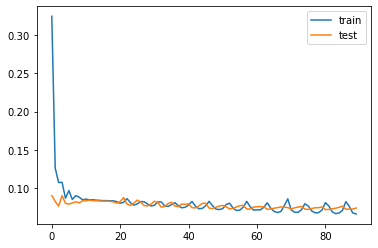

In [6]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Entrenamos la Red
history = model.fit(train_X, train_y, epochs=90, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Ploteamos el historial
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### Predicción

In [7]:
# Predicción test_X
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Invertimos la escala para pronosticar
inv_yhat = np.concatenate((yhat, test_X[:, lags * df.shape[1] - 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invertimos la escala por la actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, lags * df.shape[1] - 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# Predicción train_X
yhat_train = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))

# Invertimos la escala para pronosticar
inv_yhat_train = np.concatenate((yhat_train, train_X[:, lags * df.shape[1] - 1:]), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,0]

# Invertimos la escala por la actual
train_y = train_y.reshape((len(train_y), 1))
inv_y_train = np.concatenate((train_y, train_X[:, lags * df.shape[1] - 1:]), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y_train = inv_y_train[:,0]

In [8]:
# Cálculo del error en RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
rmse_train = sqrt(mean_squared_error(inv_y_train, inv_yhat_train))
print('Train RMSE: %.3f' % rmse_train)
print('Test RMSE: %.3f' % rmse)

Train RMSE: 4546.203
Test RMSE: 4758.104


Vemos que nuestro modelo de LSMT con KERAS es muy similar a nuestro modelo con una sola variable que hicimos en el proyecto 3 con un __Random Forest__ que tenía un error en Test en test de 4815 pero está cerca. Sin embargo, la aplicabilidad de este modelo nos permite incorporar más variables y realizar pruebas con mayor facilidad que un modelo de una sola variable.  

#### Visualización

Vamos a ver cómo se ve nuestro gráfico en el desempeño de __train_X__ y __test_X__.

In [9]:
df_dia_pred = np.around(inv_yhat, decimals=0, out=None)
df_dia_pred = pd.DataFrame(data=df_dia_pred, columns=['cantidad_pasos'])

df_dia_pred_train = np.around(inv_yhat_train, decimals=0, out=None)
df_dia_pred_train = pd.DataFrame(data=df_dia_pred_train, columns=['cantidad_pasos'])

In [10]:
df_dia = pd.read_csv('/Users/juanchi/Documents/Data Science/Curso/Proyecto 3/dataset_dia.csv', sep =',')
df_dia = df.set_index(pd.DatetimeIndex(df_dia['fecha_hora']))
df_dia.drop(columns=['dias'], inplace = True)

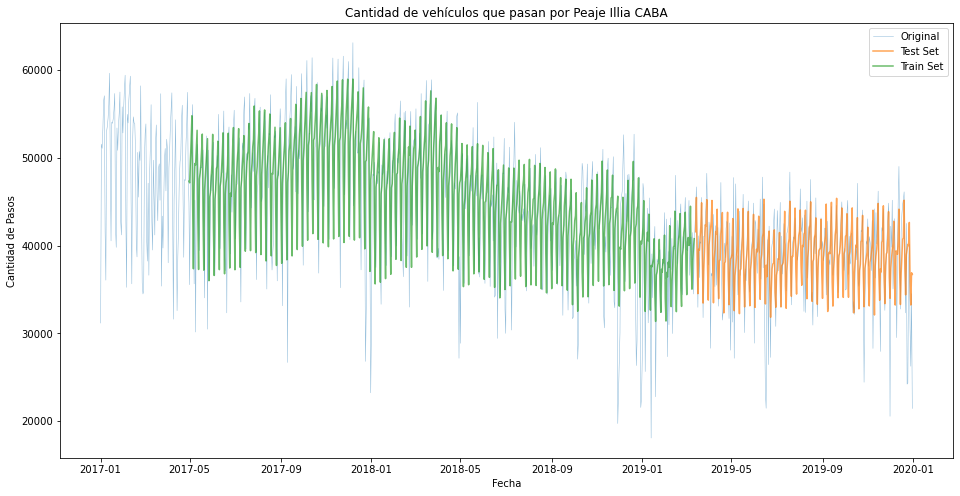

In [11]:
plt.figure(figsize=(16,8))
plt.plot(df_dia.index, df_dia.cantidad_pasos,lw = 0.5, zorder=0, alpha=0.5, label = 'Original')
plt.plot(df_dia.index[df.shape[0] - test_X.shape[0]:], df_dia_pred.cantidad_pasos, alpha=0.7, label = 'Test Set')
plt.plot(df_dia.index[lags-1:df.shape[0] - test_X.shape[0] - 1], df_dia_pred_train.cantidad_pasos, alpha=0.7, label = 'Train Set')
plt.legend()
plt.title('Cantidad de vehículos que pasan por Peaje Illia CABA')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.show()

### Pregunta a responder

Habíamos planteado que queríamos entender cuándo en la ciudad se dejaría de usar el método de pago __EFECTIVO__. En el proyecto 3 descubrimos que hay una clara tendencia a la baja del uso de este método en todos los peajes de acceso. Los factores se deben a la digitalización del servicio con Telepase, alentado por el Gobierno de la Ciudad de Buenos Aires y la transformación digital en el mundo de la finanzas (Fintechs). Sin embargo, queremos entender cúando será el momento donde orgánicamente se va a lograr eliminar este método de pago para entender si se pueden aplicar iniciativas que acelere la tendencia o esperar que el tiempo haga lo suyo. 

¿CUÁNDO SE DEJARÁ DE USAR EL MÉTODO DE PAGO __EFECTIVO__?* 

*Es importante aclarar que la búsqueda de la respuesta no contempla que factores externos que pueden acelerar o relentizar este proceso. Ej: Pandemia. 

Para esto vamos a tomar el modelo entrenado LSTM y vamos a pronosticar los años 2020, 2021. 

#### Creación de año siguiente en Pandas

In [49]:
# Creamos el dataframe para el año 2020 en los que vamos a llenar cuando nuestra predicción este hecha. 

def nuevo_año (fecha, periodo, formato):
    dataframe = pd.date_range(fecha, periods=periodo, freq=formato, normalize=True)
    dataframe = pd.DataFrame(data=dataframe,columns=['fecha_hora'])
    dataframe['cantidad_pasos'] = 0
    dataframe = dataframe.set_index(pd.DatetimeIndex(dataframe['fecha_hora']))
    dataframe.drop(columns=['fecha_hora'], inplace = True)
    dataframe['dias'] = dataframe.index.day_name()
    
    return dataframe

df2020 = nuevo_año('2020-01-01', 366, 'D') # Año Bisiesto

df2 = df.copy()

In [13]:
df2.iloc[1094]

cantidad_pasos      21447
dias              Tuesday
Name: 2019-12-31, dtype: object

#### Predicción 2020 con LSTM Multivariate

En el siguiente código, con el modelo ya entrenado con los datos de __2017__, __2018__ y __2019__, sumando un día a la vez del __2020__ vamos generando la predicción. Esa predicción la sumamos al dataset original, y volvemos loopear ahora con un día más que incluye dentro de su predicción el día anterior que hemos predicho. La predicción la vamos a hacer para los 366 días del 2020 que fue un año bisiesto. 

In [14]:
n = np.arange(366)
results = []

for i in n:
    
    if df2.iloc[1094 + i, 0] >= 0:
            
        df2 = df2.append(df2020.iloc[0 + i])
        #print(df2.iloc[1094 + i])
        values = df2.values
        encoder = LabelEncoder()
        values[:,1] = encoder.fit_transform(values[:,1])
        values = values.astype('float32')
    
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(values)
    
        lags = 120
        reframed = series_to_supervised(scaled, lags , 1)
    
        reframed.drop(reframed.columns[[lags * df2.shape[1] + 1]], axis=1, inplace=True)
    
        values = reframed.values
        test = values

        test_X, test_y = test[:, :-1], test[:, -1]
    
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
        yhat = model.predict(test_X[975 + i :])
        new = test_X[975 + i:].reshape((test_X[975 + i:].shape[0], test_X[975 + i:].shape[2]))
    
        inv_yhat = np.concatenate((yhat, new[:,lags * df2.shape[1] - 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
    
        df2.iloc[1095 + i, 0] = np.around(inv_yhat[0])
        #results.append(inv_yhat[0])
    
        #print(inv_yhat)
    else:
        break

In [15]:
df2 = df2.set_index(pd.to_datetime(df2.index,format="%Y-%m-%d"))

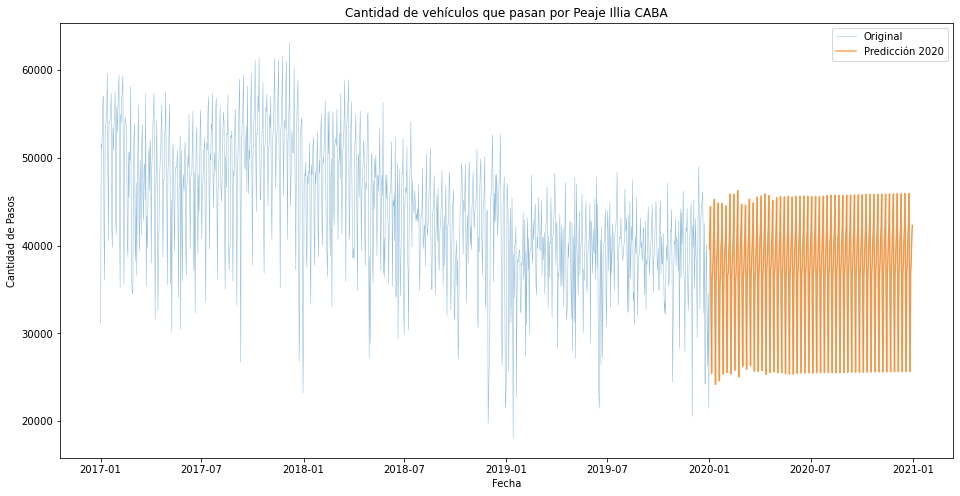

In [16]:
plt.figure(figsize=(16,8))
plt.plot(df2.index, df2.cantidad_pasos,lw = 0.5, zorder=0, alpha=0.5, label = 'Original')
plt.plot(df2.index[1095:], df2.cantidad_pasos[1095:], zorder=0, alpha=0.7, label = 'Predicción 2020')
plt.legend()
plt.title('Cantidad de vehículos que pasan por Peaje Illia CABA')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.show()

Nuestro modelo de __LSTM con Keras con multiples variables (Mutlivariate)__ no es un modelo que esta performando como esperábamos y claramente la suma del `días` como variabe extra no genera mejoras sustenciales que justifiquen el costo computacional y complejidad de modelo. Este modelo no nos permite responder nuestra pregunta inicial de cuando se dejará de usar el método efectivo en el peaje Illia. Sin embargo, queríamos aplicar un modelo LSTM al problema para entender si funcionaba mejor. 

Quedaría hacer otro tipo de pruebas que podemos realizar con el objetivo de mejorar el modelo. Probar el mismo modelo pero solo con la variable de `cantidad_pasos` por ejemplo, optimizar mejor los hiperparámetros, usar __get_dummies__ o __oneHotEncoder__ y quitar la estacionalidad de la serie. 

#### Predicción 2020 con RandomForest Univariate

##### Modelo del proyecto 3

In [257]:
df3 = df2.cantidad_pasos[:1095]

# Definimos X e y
look_back = 120

N = df3.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

for i in range(X.shape[0]):
    X[i,:] = df3.iloc[i:i+look_back]
    y[i] = df3.iloc[i+look_back]
    
N_train = int(y.shape[0]*0.7) # cantidad de instancias que vamos a usar para entrenar.
N_test =  int(y.shape[0]*0.3) #cantidad de puntos que vamos a usar para evaluar. 
N_total = N_train + N_test

length_total = N_train + N_test + look_back 

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4).fit(X_train,y_train)

y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

(974, 120) (974,)
(681, 120) (681,)
(292, 120) (292,)


##### Proyección 2020 

In [258]:
df2020_2 = df2020.copy()
df2020_2 = df2020.drop(['dias'], axis=1)
df2020_2
df2020_3 = df2020_2.copy()

n = np.arange(366)

for a in n:
    
    df3 = df3.append(df2020_2.iloc[0 + a], ignore_index=True)
    #print(df3.shape)
    
    look_back = 120
    N = df3.shape[0] #1096
    X = np.zeros((N - look_back,look_back)) #1095 - 120 - 1 = 975
    
    for i in range(X.shape[0]):
        X[i,:] = df3.iloc[i:i+look_back]
     
    X_test = X[:,:]
    y_pred = rf.predict(X_test[975+a:,:])
    df3.iloc[1095 + a] = np.around(y_pred[0])
        
    #print(X_test.shape)
    #print(y_pred)

In [248]:
df4 = pd.DataFrame(data=df3)
df5 = pd.date_range('2017-01-01', periods=1461, freq='D')
df5 = pd.DataFrame(data=df5,columns=['fecha_hora'])
df5['cantidad_pasos'] = df4
df5 = df5.set_index(pd.DatetimeIndex(df5['fecha_hora']))
df5.drop(columns=['fecha_hora'], inplace = True)

In [280]:
from sklearn.linear_model import LinearRegression

df5['fecha_numeros']=df5.index.map(datetime.datetime.toordinal)
lr = LinearRegression()
lr.fit(df5.fecha_numeros.values.reshape(-1, 1), df5.cantidad_pasos)

LinearRegression()

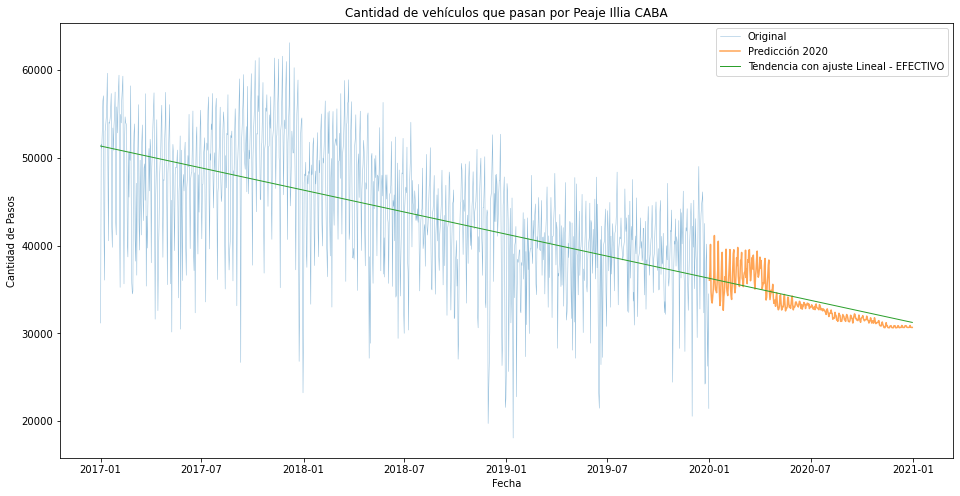

In [281]:
plt.figure(figsize=(16,8))
plt.plot(df5.index[:1095], df5.cantidad_pasos[:1095],lw = 0.5, zorder=0, alpha=0.5, label = 'Original')
plt.plot(df5.index[1095:], df5.cantidad_pasos[1095:], zorder=0, alpha=0.7, label = 'Predicción 2020')
plt.plot(df5.index, lr.predict(df5.fecha_numeros.values.reshape(-1, 1)), lw = 1, label = 'Tendencia con ajuste Lineal - EFECTIVO')
plt.legend()
plt.title('Cantidad de vehículos que pasan por Peaje Illia CABA')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.show()

In [278]:
print('Promedio de pases 2017 =', df5.cantidad_pasos[:364].mean())
print('Promedio de pases 2018 =', df5.cantidad_pasos[365:729].mean())
print('Promedio de pases 2019 =', df5.cantidad_pasos[730:1094].mean())
print('Promedio de pases 2020 =', df5.cantidad_pasos[1095:].mean())

Promedio de pases 2017 = 48944.45054945055
Promedio de pases 2018 = 44157.71978021978
Promedio de pases 2019 = 38829.756868131866
Promedio de pases 2020 = 33465.89890710382


Este último modelo de __RandomForest__ con una sola variable responde mejor a lo que búscabamos. Si bien, no predice correctamente los picos semanales de pases sigue la tendencia negativa que vimos en el proyecto anterior. Notamos también, que el modelo baja su rendimiento una vez pasado los 120 lags donde empieza a predecir 100% con los datos predichos. 

Como conclusión para este problema podemos decir que desde __2017 a 2020_ según nuestro análisis hubo un baja de `cantidad_pasos` de __32%__ en un lapso de 4 años calendario. 

En relación a año contra año:
De 2017 al 2018 hubo __-10%__.
De 2018 a 2019 hubo __-13%__.
De 2019 a 2020 deberíamos esperar una baja del __-14%__. 


In [297]:
z = 0.85
x = df5.cantidad_pasos[1095:].mean()
l = 0

for m in n:
    if x >= 5000:
        x = x * z
        l =  l + 1
        
    else:
        break
print(l)

12


Si no hubiera ningún otro factor externo que se sume a los que ya están en juego podríamos suponer que __12 años__ la cantidad de pases en el peaje Illia va estar por debajo de los __5.000__ diarios. Es importante decir, que en 2020 el __Gobierno de la Ciudad de Buenos Aires__ [dispuso como obligatorio el Telepase como método de pago para todos sus peajes](https://www.buenosaires.gob.ar/jefaturadegabinete/movilidad/noticias/por-el-alto-numero-de-adhesiones-diarias-habra-tiempo-hasta-el). Seguramente este nuevo factor, sumado a la explosión de la pandemia, ha aumentado notablemente la baja de uso de efectivo. 